<a name="top"> <h1>6. Graphs</h1> <a>

<p>Yelp Dataset- Stars Prediction<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

### Estructura

[0. Introducción](#introduccion) 


[1. Importación de librerias](#librerias) 


[2. Carga de datos](#datos) 
   
[3. Grafo de distancias](#grafo) 

   - Transformación de los datos
   - Creación del grafo
   - Visualización

   
[4. Conclusiones Generales](#conclusiones)

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 


Este notebook está destinado a la realización de grafos. El graficado de un grafo resulta muy útil para representar relaciones entre distintos elementos. En este caso, con los ficheros utiliados para nuestro caso de negocio, podemos aprovechar las características geográficas para medir la distancia entre distintos restaurantes.

 Aprovechando las columnas de `latidud` y `longitud` se puede medir la distancia entre ellos y ver dónde se aglomeran más restaurantes. Esto serviría para realizar un estudio de mercado y ver dónde se podría abrir un nuevo restaurante, además de otros casos de negocio.

# <a name="librerias"> 1. Importación de librerias <a> 


In [1]:
# Ignore warnings.

import warnings
warnings.filterwarnings("ignore")

# Import general libraries and geopy to calculate distances.

import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Import graph libraries.

import networkx as nx

# <a name="datos"> 2. Carga de datos <a> 

Para calcular la distancia entre diferentes restaurantes, deberemos cargar `business_df` y `restaurants_df`. Dado que filtraremos los business_id pertenecientes a los restaurantes que se encuentran en el fichero restaurants con el objetivo de obtener los detalles geográficos.

In [2]:
business = pd.read_parquet('../data/processed/business_df.parquet')

In [3]:
restaurants = pd.read_parquet('../data/processed/restaurants_df.parquet')

# <a name="grafo"> 3. Grafo de distancias <a> 

## 3.1. Transformación de los datos

En primer lugar filtramos, los ID de cada local con el objetivo de quedarnos únicamente con los restaurantes. Una vez realiazdo, procedemos a qeudarnos con las variables que nos interesan, eliminando los atributos, dado que no los vamos a necesitar.

In [4]:
# Select rows that are in restaurants_df from business.

business = business[business['business_id'].isin(restaurants['business_id'])]

# Select the first 8 columns from business

business = business.iloc[:, :8]

# Show the states with the most restaurants.

business['state'].value_counts().head(15)

PA    7929
FL    5856
TN    2976
IN    2809
MO    2707
NJ    2377
LA    2328
AZ    1775
AB    1690
NV    1068
ID     930
IL     717
DE     692
CA     660
HI       1
Name: state, dtype: int64

Para este caso de uso se va a realizar el grafo que mide las distancias entre los restaurantes del Estado de California, puesto que es el que menos restaurantes tiene y por limitación computacional es más factible de realizar, sin embargo, contando con dispositivos más desarrollados se puede realizar de cualquier estado.

Para poder calcular las distancias es necesario tener las coordenadas de los restaurantes en una tupla de la forma `(latitud, longitud)`. Para ello se crea una nueva columna con esta información `lat_long`.

In [5]:
# Select the California State.

california = business[business['state'] == 'CA']

# Create a column with a tuple of latitude and longitude.

california['lat_long'] = list(zip(california['latitude'], california['longitude']))

# Select columns of name and lat_long.

california = california[['name', 'lat_long']]

Reseteamos el indice y previsualizamos el resultado de la tabla `california`.

In [6]:
# Reset index of California.

california = california.reset_index(drop=True)

# Display the DF.

california.head()

,name,lat_long
0,Helena Avenue Bakery,"(34.4144445, -119.6906718)"
1,Santa Barbara Shellfish Company,"(34.4087147, -119.6850187)"
2,Marty's Pizza,"(34.4362361, -119.7261474)"
3,Cal Taco,"(34.4305419, -119.882367)"
4,Pho Bistro,"(34.4129345, -119.8555307)"


Ahora se calculan las distancias basándonos en las coordenadas anteriores. Para ello utilizaremos la librería geodesic, la cual nos calcualará la distancia en millas entre cada restaurante, dado que se encuentran en Estados Unidos.

In [7]:
# Using lat_long , calculate the distance between the restaurants and create a dataframe with the names of both restaurants and the distance.

distances = []

for i in range(len(california)):
    for j in range(i+1, len(california)):
        distances.append((california['name'][i], california['name'][j], geodesic(california['lat_long'][i], california['lat_long'][j]).miles))

# Create a dataframe with the distances.

distances_df = pd.DataFrame(distances, columns=['name1', 'name2', 'distance'])

# Display the DF.

distances_df.head()

,name1,name2,distance
0,Helena Avenue Bakery,Santa Barbara Shellfish Company,0.510173
1,Helena Avenue Bakery,Marty's Pizza,2.522304
2,Helena Avenue Bakery,Cal Taco,11.005604
3,Helena Avenue Bakery,Pho Bistro,9.418216
4,Helena Avenue Bakery,Rusty's Pizza Parlor,10.256238


**Como observamos, hemos obtenido una tabla de adyacencia con la conexión entre diferentes restaurantes utilizando como pesos la distancia.** 

## 3.2. Creación del grafo

A través de la tabla de adyacencia `distances_df`, creamos un grafo a través de la librería Networkx, asignando la columna `name1` como origen, `name2` como destino y `distance` como pesos. 

In [8]:
# Create the graph from distances_df where origin is name1 and destination is name2 with weights equal to distance. 

G = nx.from_pandas_edgelist(distances_df, source='name1', target='name2', edge_attr='distance', create_using=nx.DiGraph())

# Export the graph to a .gexf file.

nx.write_gexf(G, "../data/graphs/distance_graph.gexf")

**Con la librería de networkx es posible visualizar graficamente el grafo, sin embargo, es muy básico y no permite ver correctamente la distribución, por lo que hemos decidido exportarlo como .gexf con el objetivo de tratarlo en Gephi, dado que este programa permite visualizar el grafo de manera interactiva. Como tenemos muchos nodos resulta dificil de visualizar si no es de esta manera.**

## 3.3. Visualización

Uno de los muchos casos de uso, sería encontrar el locla dentro del estado de california más centrico, con el objetivo de en caso de montar un local o crear una red de riders, encontrarse en el lugar donde haya menos distancia entre los distintos restaurantes.

Para ello hemos procedido a seleccionar tamaño y paleta de color en función del grado medio de los pesos, por lo que los puntos más pequeños y de tonalidad más oscura, son los que menor grado medio tienen. Mediante gephi, podemos observar la distribución sin solapamiento de esta manera:

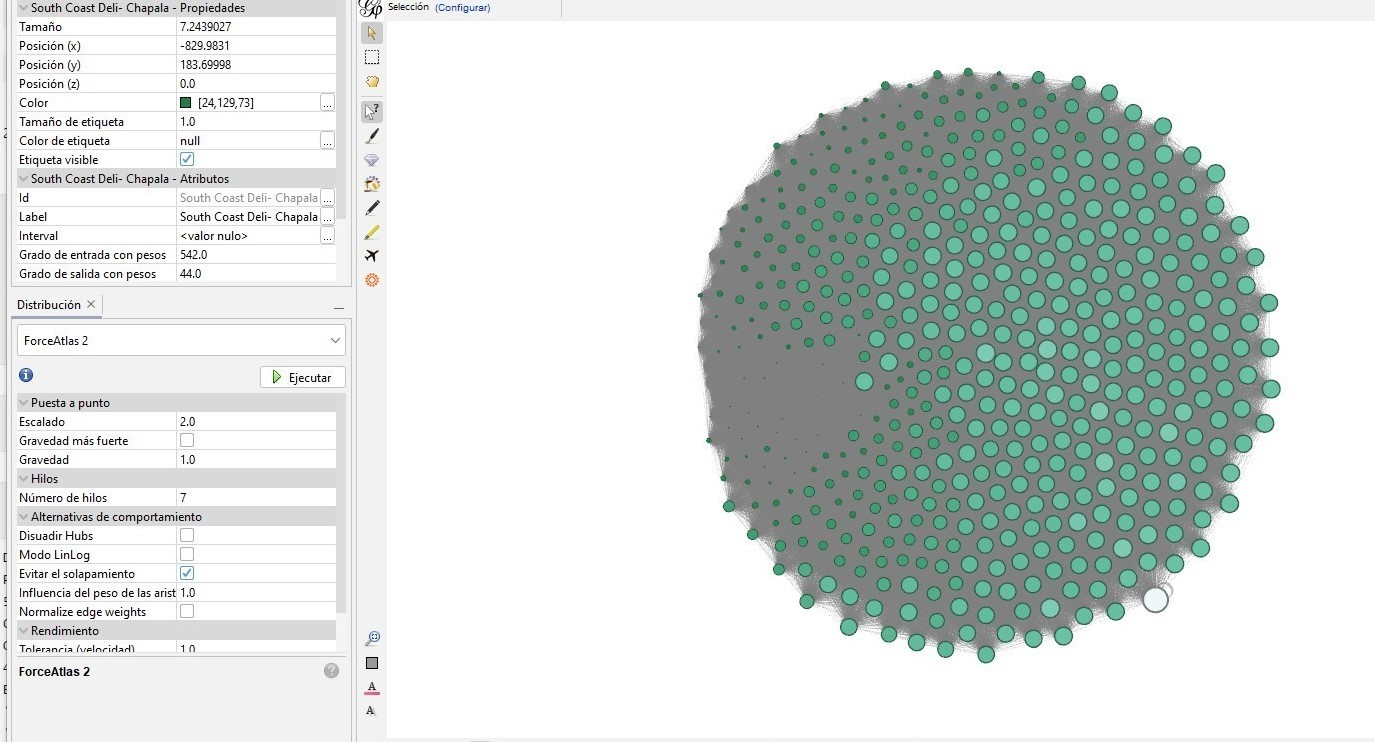


Además podemos observar las conexiones existentes entre los distintos puntos como podemos observar en la imagen inferior:

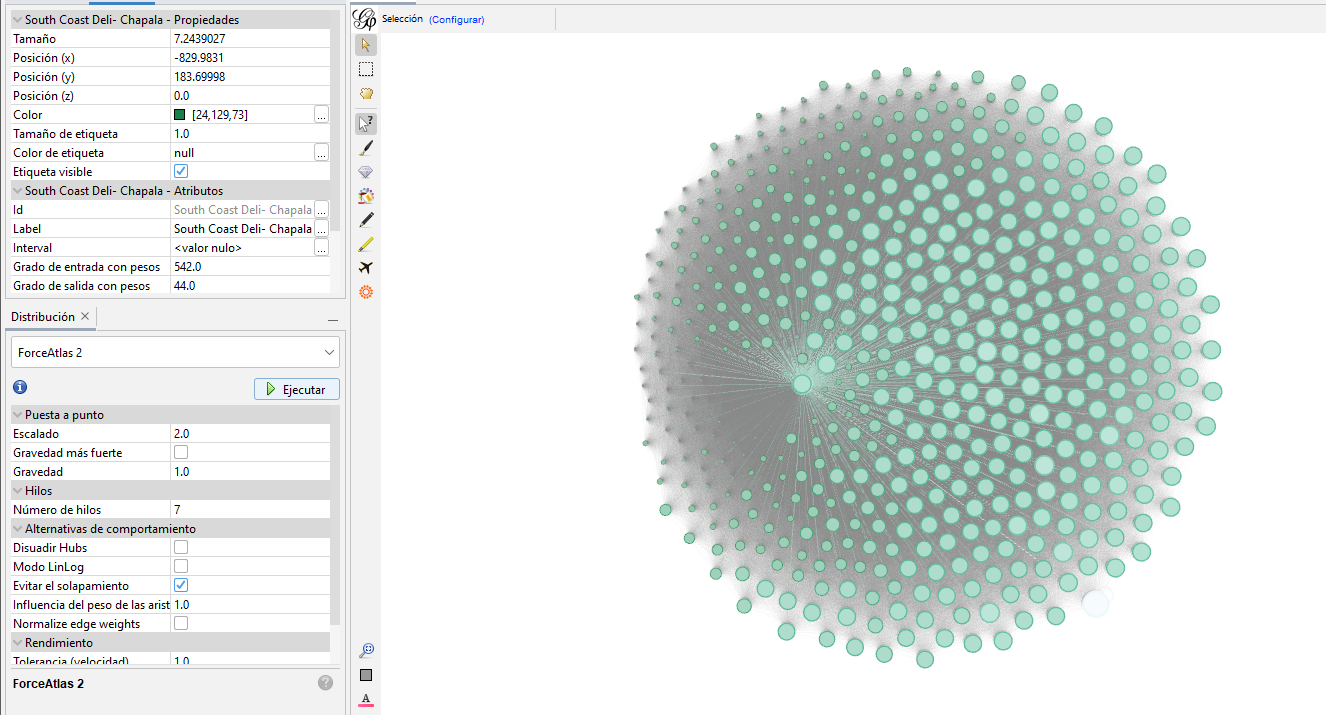

Mediante la librería networkx podemos visualizar también los restaurantes con mayor centralidad de una forma directa:

In [11]:
# Calculate the wighted degree centrality of the graph. 

nx.degree_centrality(G)

# Show the top 10 restaurants with the highest degree centrality.

sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)[:10]



[('Panda Express', 1.8998272884283247),
 ('Sushi Teri', 1.8877374784110534),
 ('KFC', 1.8307426597582037),
 ("Domino's Pizza", 1.8169257340241796),
 ('Taqueria Rincon Alteno', 1.8151986183074265),
 ("McDonald's", 1.768566493955095),
 ("Rusty's Pizza Parlor", 1.7668393782383418),
 ("Sam's To Go", 1.7512953367875648),
 ('Los Agaves', 1.7478411053540586),
 ('Broad Street Oyster Company', 1.7081174438687392)]

# <a name="conclusiones"> 4. Conclusiones generales <a> 

**- Con los ficheros utilizados para la creación de nuestro modelo podemos crear tablas de adyacencia para diferentes casos de uso, como localizar el restaurante más centrico del estado para hacerse una idea de que sitio es el idóneo para montar un restaurante o crear una red de riders.**

**- La librería Networkx permite construir lso grafos a través de tablas de adyacencia, sin embargo, para la visualización de los mismos es más recomendable utilizar un software externo como Gephi.**

**- Según el caso de negocio mediante Networkx podemos obtener información importante de los valores utilizados, como el orden por centralidad, calcular grados de salida, de entrada, clustering, etc..**

**- En este caso hemos procedido a realizar un ejemplo con los ficheros que hemos utilizado durante la práctica, sin embargo, el dataset de Yelp es muy extenso y podrían construirse relaciones entre diferentes usuarios, con el dataset `yelp_academic_dataset_user`, palabras de las reviews utilizando `yelp_academic_dataset_review`, etc...** 



[Ir arriba del documento](#top)